<a href="https://colab.research.google.com/github/stefanmzeidler/HI744_Programming_Assignment_1/blob/main/Zeidler_Programming_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs, downloads, and imports

In [11]:
!pip install gensim
!pip install nltk

In [12]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Util Functions

In [13]:
#Provided by Professor He
import nltk
import json
import os
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
import sys

def read_txt_files_from_directory(directory_path):
    file_contents = {}
    try:
        for filename in os.listdir(directory_path):
            if filename.endswith('.txt'):
                file_path = os.path.join(directory_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        file_contents[filename] = file.read()
                except Exception as e:
                    print(f"An error occurred while reading {filename}: {e}")
    except Exception as e:
        print(f"An error occurred while accessing the directory: {e}")
        return {}
    return file_contents

def load_from_json(filename):
    try:
        with open(filename, 'r') as json_file:
            data = json.load(json_file)
        return data
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return None

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = []
    for token in tokens:
        if token not in stop_words:
            filtered_sentence.append(token)
    return filtered_sentence

def stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def pre_process(text):
    text_lower = text.lower()
    tokens_no_punctuation = remove_punctuation(text_lower)
    filtered_tokens = remove_stop_words(tokens_no_punctuation)
    stemmed_tokens = stemming(filtered_tokens)
    return stemmed_tokens

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def top_5(vector_matrix, data, column_name):
  """
  Inserts the top 5 most similar indices for a given matrix of vectors into a dataframe.
  :param vector_matrix: Matrix of vectors.
  :param data: Dataframe to insert top5 list.
  :param column_name: Name for new column containing the top 5.
  """
  sim_matrix = cosine_similarity(vector_matrix)
  top5_indices = np.argpartition(-sim_matrix, range(6), axis=1)[:, 1:6].tolist()
  data[column_name] = top5_indices
  data[column_name] = data[column_name].apply(lambda x: index_to_id(data, x))

def index_to_id(data, index_list)->list[str]:
  """
  Given a list of indices, returns the patient UID from a given dataframe.
  :param data:Dataframe containing the patient UID.`
  :param index_list:List of indices for each patient
  :return:List of patient_ID strings
  """
  id_list = []
  for i in index_list:
    id_list.append(data.at[i,'patient_uid'])
  return id_list


# TF-IDF Similarity

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_similarity(data):
  tfidf = TfidfVectorizer()
  vector_matrix = tfidf.fit_transform(data['patient'])
  top_5(vector_matrix, data, 'similar_patients_tfidf')

# Doc2Vec Similarity

In [16]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

#Adapted from https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
def read_corpus(data, tokens_only = False):
    documents = data['tokens']
    for i, tokens in documents.items():
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

def train_doc2vec(data):
  model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=1, epochs=40)
  train_corpus = list(read_corpus(data))
  model.build_vocab(train_corpus)
  print("Vocab built")
  print("Starting training")
  model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
  fname = get_tmpfile(os.path.join(PROJ_DIRECTORY,"my_doc2vec_model"))
  model.save(fname)
  print("Model saved")
  return model

def doc2vec_vectors(model, data):
  vector_matrix = []
  print("Calcualting Doc2Vec vectors")
  for _ , tokens in data['tokens'].items():
    vector_matrix.append(np.array(model.infer_vector(tokens)))
  print("Vectors calculated")
  return vector_matrix


def load_model(fname):
  return Doc2Vec.load(fname)

def doc2vec_similarity(data):
  doc2vec_model = train_doc2vec(data)
  vector_matrix = doc2vec_vectors(doc2vec_model,data)
  top_5(vector_matrix, data,'similar_patients_doc2vec')







In [17]:
def gen_similar_patients(data):
    similar_patients = data[['patient_uid','similar_patients_tfidf','similar_patients_doc2vec']]
    similar_patients.to_json('similar_patients.json',orient='records')



In [18]:
from sklearn.metrics import precision_score
import ast
def generate_metrics(data):
    data['similar_patients'] = data['similar_patients'].apply(lambda x: string_to_list(x))
    data['doc2vec_precision'],data['doc2vec_recall'] = zip(*data.apply(lambda row:calc_precision_recall(row['similar_patients'],row['similar_patients_doc2vec']), axis=1))
    data['tfidf_precision'],data['tfidf_recall'] = zip(*data.apply(lambda row:calc_precision_recall(row['similar_patients'],row['similar_patients_tfidf']), axis=1))
    metrics = data[['patient_uid','doc2vec_precision','doc2vec_recall', 'tfidf_precision','tfidf_recall']]
    metrics.to_json('metrics.json',orient='records')

def string_to_list(text):
    if type(text) == list:
        return text
    else:
        return list(ast.literal_eval(text).keys())
def calc_precision_recall(y_true, y_pred):
    true_positives = len([patient for patient in y_pred if patient in y_true])
    false_positives = len(y_pred) - true_positives
    false_negatives = len(y_true) - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = 0 if true_positives + false_negatives  == 0 else true_positives / (true_positives + false_negatives)
    return precision,recall




In [25]:
import matplotlib.pyplot as plt
def plot_precision_recall(data):
    categories = np.array(["doc2vec_precision", "tfidf_precision", "doc2vec_recall", "tfidf_recall"])
    doc2vec_avg_precision = data['doc2vec_precision'].mean()
    doc2vec_avg_rec = data['doc2vec_recall'].mean()
    tfidf_avg_precision = data['tfidf_precision'].mean()
    tfidf_avg_rec = data['tfidf_recall'].mean()
    values = np.array([doc2vec_avg_precision, doc2vec_avg_rec, tfidf_avg_precision, tfidf_avg_rec])
    plt.bar(categories, values, color = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange'])
    plt.xlabel("Document Representation")
    plt.ylabel("Score")
    plt.title("Average Precision and Recall @5 for Doc2Vec and TF-IDF")
    plt.show()

In [19]:
PROJ_DIRECTORY =os.getcwd()
dataset = load_dataset("PMC-Patients.csv",nrows=1000)
doc2vec_similarity(dataset)
tfidf_similarity(dataset)
gen_similar_patients(dataset)
generate_metrics(dataset)
plot_precision_recall(dataset)



Data loaded
Vocab built
Starting training


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Model saved
Calcualting Doc2Vec vectors


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vectors calculated


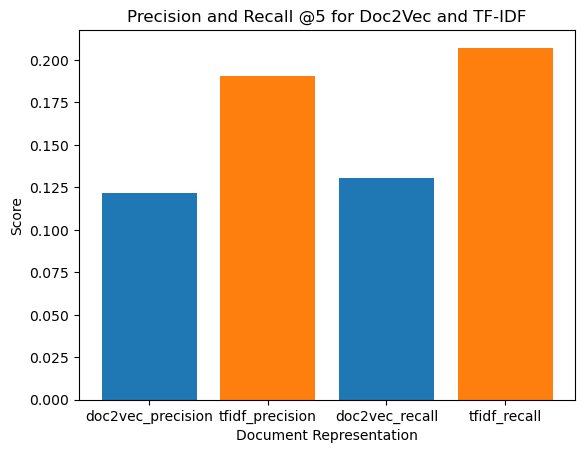

In [24]:
plot_precision_recall(dataset)